In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID_0'
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AE66GAm2HDOHof1uhNoyum8hh1yVBDSYERQ7JX05cVZLVpdOjESbcI
Mounted at /content/drive
/content/drive/My Drive/COVID_0
 Covid2.ipynb	        inceptionv3chest_00.hdf5   NORMAL
 Data		        inceptionv3chest_0.hdf5    Test
 inceptionchest_00.h5   inceptionv3chest_1.hdf5    vggchest2_0.h5
 inceptionchest_0.h5    inceptionv3chest_2.hdf5   'VGG chest.ipynb'
 inceptionchest_1.h5    InceptionV3_Chest.ipynb    vggweightschest0.hdf5


In [ ]:
from __future__ import print_function, division
from builtins import range, input
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] 

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'Data/Chest_COVID'
noncovid_path = 'Data/Chest_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

In [ ]:
len(covid_labels)
len(noncovid_labels)

1947





#### Model takes images in the form of array of pixels. Hence convert into array

In [ ]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### **Compile model**

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### **Training the model**

In [ ]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold,th):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
        self.th=th
    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        acc=logs["accuracy"]
        if acc>=self.th:
          if val_acc >= self.threshold:
            self.model.stop_training = True

In [ ]:
my_callback = MyThresholdCallback(threshold=0.94,th=0.95)
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500,
                    callbacks=[my_callback])

Epoch 1/500
99/98 [==============================] - 37s 378ms/step - loss: 1.2275 - accuracy: 0.8400 - val_loss: 0.6657 - val_accuracy: 0.9033
Epoch 2/500
99/98 [==============================] - 36s 360ms/step - loss: 1.2158 - accuracy: 0.8827 - val_loss: 0.6993 - val_accuracy: 0.9071
Epoch 3/500
99/98 [==============================] - 35s 358ms/step - loss: 0.8082 - accuracy: 0.8872 - val_loss: 0.8469 - val_accuracy: 0.9046
Epoch 4/500
99/98 [==============================] - 35s 356ms/step - loss: 0.8455 - accuracy: 0.8974 - val_loss: 0.5874 - val_accuracy: 0.9160
Epoch 5/500
99/98 [==============================] - 35s 358ms/step - loss: 1.1052 - accuracy: 0.8865 - val_loss: 0.9384 - val_accuracy: 0.9109
Epoch 6/500
99/98 [==============================] - 36s 360ms/step - loss: 1.4471 - accuracy: 0.8840 - val_loss: 0.7990 - val_accuracy: 0.9211
Epoch 7/500
99/98 [==============================] - 35s 357ms/step - loss: 0.9967 - accuracy: 0.9123 - val_loss: 0.6459 - val_accuracy:

In [ ]:
model.save('inceptionchest_00matr.h5')

In [ ]:
model.save('inceptionchest_00.h5')

In [ ]:
model.save_weights('inceptionv3chest_00matr.hdf5')

In [ ]:
model.save_weights('inceptionv3chest_00.hdf5')

In [ ]:
model = load_model('inceptionchest_00matr.h5')

In [ ]:
path='Test/'

### **Making Predicions of Unseen data (covid total=1161,non covid total=250)**

#after prediction 
**94% acc in train and 95% val(model-1) gives 1379 correct result and 21 wrong in unseen data**

**94% acc in train and val (model-2) gives 1352 correct result and 46 wrong in unseen data**

In [ ]:
c=0
o=0
for x in os.listdir(path):
  #print(x)
  image = cv2.imread(path+x) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224))
  image = np.array(image) / 255
  image = np.expand_dims(image, axis=0)
  
  y_pred = model.predict(image)
  probability = y_pred[0]
  if probability[0] > 0.5:
    c=c+1
    vgg_chest_pred = str(' COVID') 
    
  else:
    o=o+1
    vgg_chest_pred = str('NonCOVID')
print(c)
print(o)

NameError: ignored

### Check on my data predictions

In [ ]:
probability = y_pred[0]
print("VGG Predictions:")
if probability[0] > 0.5:
  vgg_chest_pred = str(' COVID') 
else:
  vgg_chest_pred = str('NonCOVID')
print(vgg_chest_pred)

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

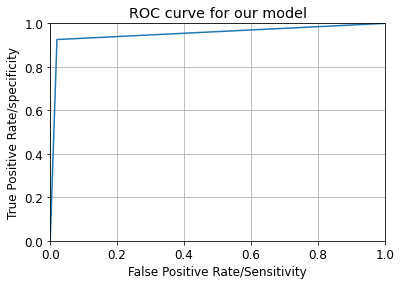

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate/Sensitivity')
plt.ylabel('True Positive Rate/specificity')
plt.savefig('inception_roc.png')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


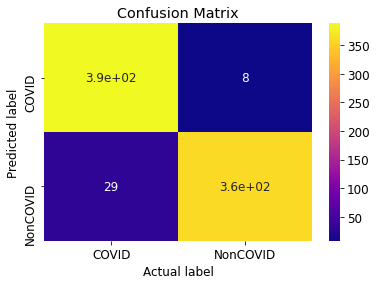

Confusion Matrix with Normalized Values


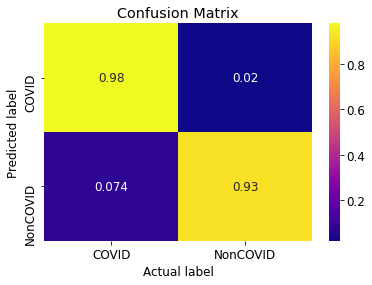

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('Predicted label')
  plt.xlabel('Actual label')
  plt.savefig('inception_cm.png')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       396
           1       0.98      0.93      0.95       390

    accuracy                           0.95       786
   macro avg       0.95      0.95      0.95       786
weighted avg       0.95      0.95      0.95       786

